In [2]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt

Global seed set to 0


# Read data

In [3]:
adata = sc.read('../../retina/retina.h5ad')

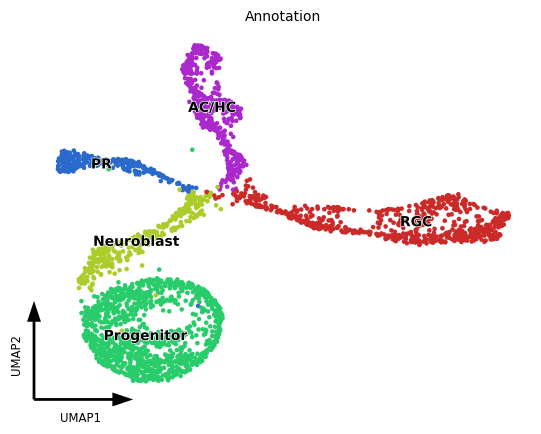

In [4]:
scv.pl.umap(adata, color='Annotation', frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
adata = ltv.utils.standard_clean_recipe(adata)

Filtered out 25381 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.VAE(observed=2000, latent_dim=20, zr_dim=2, h_dim=2)

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100,
                                      epochs=50, name='retina_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
656 velocity genes used
epoch 0, full loss 180.256, val loss 115.298, recon MSE 2.326, traj MSE 0.528, reg loss -2.713
epoch 1, full loss 106.146, val loss 59.776, recon MSE 2.017, traj MSE 0.458, reg loss -3.199
epoch 2, full loss 62.308, val loss 14.753, recon MSE 1.653, traj MSE 0.449, reg loss -3.656
epoch 3, full loss 18.565, val loss -32.330, recon MSE 1.279, traj MSE 0.441, reg loss -3.957
epoch 4, full loss -15.194, val loss -78.926, recon MSE 0.918, traj MSE 0.396, reg loss -3.365
epoch 5, full loss -43.352, val loss -125.581, recon MSE 0.735, traj MSE 0.354, reg loss -2.051
epoch 6, full loss -61.355, val loss -171.860, recon MSE 0.674, traj MSE 0.340, reg loss -1.933
epoch 7, full loss -69.821, val loss -213.905, recon MSE 0.616, traj MSE 0.307, reg loss -2.400
epoch 8, full loss -73.871, val loss -249.555, recon MSE 0.585, traj MSE 0.304, reg loss -2.265
epoch 9, full loss -79.797, val loss -276.979, recon M

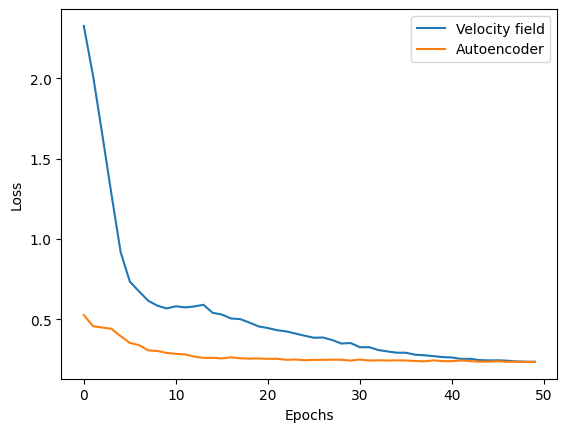

In [7]:
ltv.plot_history(epochs, val_ae, val_traj)
plt.show()

# Compute velocities and plot on UMAP

In [8]:
latent_adata = ltv.output_results(model, adata, decoded=True)

In [9]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2726 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


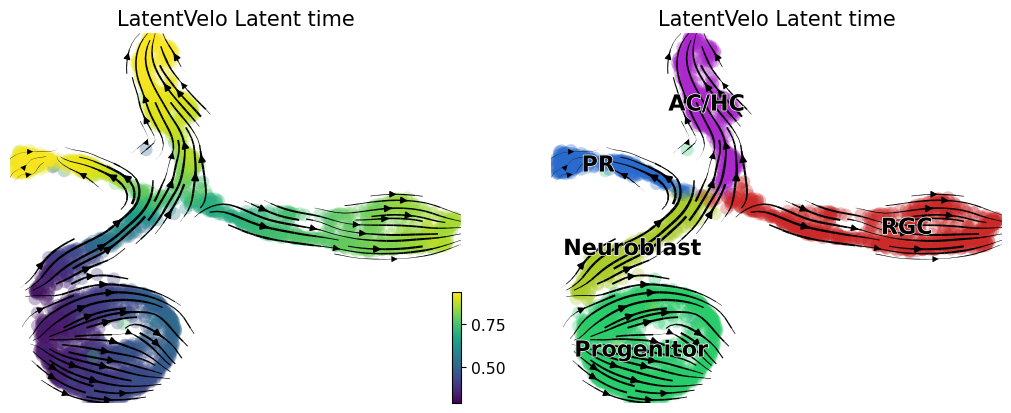

In [10]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', title='LatentVelo Latent time',
                                color=['latent_time', 'Annotation'], fontsize=15,
              legend_fontsize=16, cutoff_perc=0)

saving figure to file ../figures/retina_model_umap_lineages.png


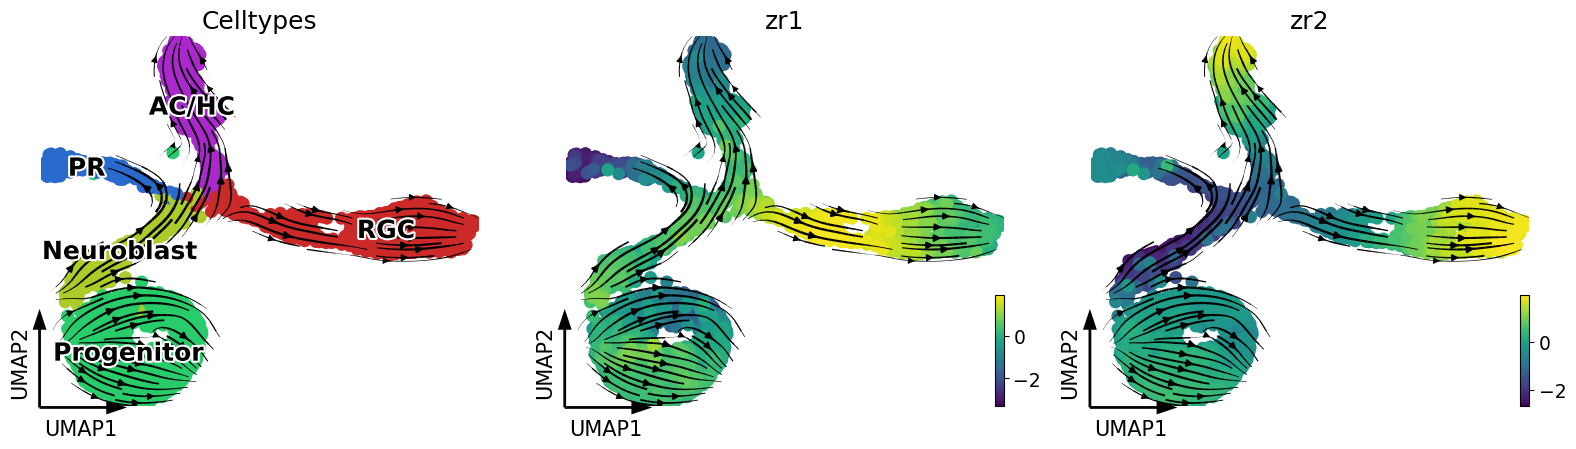

In [11]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['Annotation', 'zr1', 'zr2'], 
                                 title=['Celltypes', 'zr1', 'zr2'], alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='../figures/retina_model_umap_lineages.png')

In [12]:
# save fit
latent_adata.write('../benchmark/real_data/fits/retina_latent_adata.h5ad')

# Compute CBDir scores

In [13]:
retina_edges = [
        ('Neuroblast', 'PR'),
        ('Neuroblast', 'AC/HC'), 
        ('Neuroblast', 'RGC')]

In [15]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
retina_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'Annotation', 'spliced_velocity_pca', retina_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


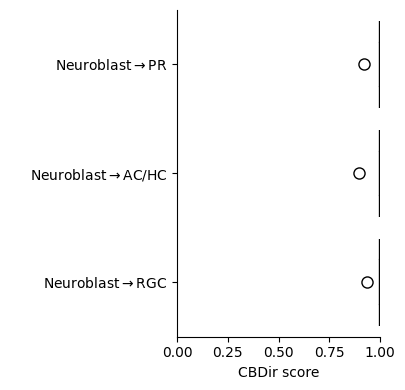

In [16]:
ax=ltv.pl.transition_scores(retina_pca, raw=True)
ax.set(xlim=(0,1))
plt.savefig('figures/retina_transitions.pdf')
plt.show()

# Plot z_r scatter and compute lineage classification accuracy from z_r

Renamed 'zr' to convention 'X_zr' (adata.obsm).
saving figure to file ../figures/retina_zr_plot.png


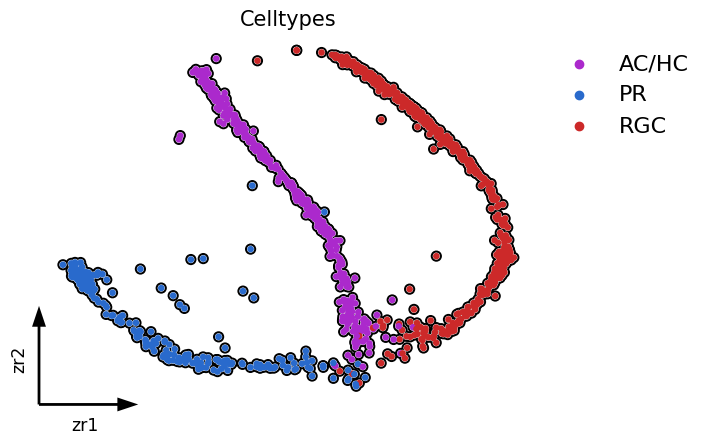

In [17]:
scv.pl.scatter(latent_adata[latent_adata.obs.Annotation.isin(['PR', 'AC/HC', 'RGC'])],
               'zr', color='Annotation', frameon='artist', title='Celltypes', fontsize=15,
              legend_fontsize=16, add_outline=True, save='../figures/retina_zr_plot.png')